# Generative Model - Conditional Variational Auto Encoder
Affandy Fahrizain - J42332c

In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [2]:
# hyperparameters
BATCH_SIZE = 512
LATENT_SIZE = 10
ENC_LAYERS = [784, 512, 256, 128]
DEC_LAYERS = [LATENT_SIZE, 256, 512, 784]
NUM_LABELS = 10
LEARNING_RATE = 1e-4
EPOCHS = 300
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = FashionMNIST('data', train=True, transform=transform, download=True)
testset = FashionMNIST('data', train=False, transform=transform, download=True)
trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=True)

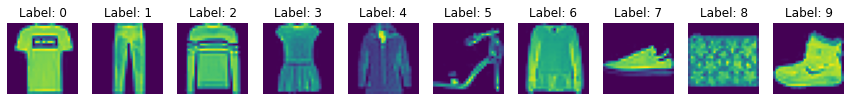

In [4]:
label_plotted = []
fig, ax = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(15, 10))
for ft, lb in trainset:
    if lb not in label_plotted:
        ax[lb].imshow(ft.squeeze())
        ax[lb].axis('off')
        ax[lb].set_title(f'Label: {lb}')
        label_plotted.append(lb)

    if len(label_plotted) >= 10:
        break
plt.show()

In [5]:
def one_hot(labels, num_labels):
    if labels.dim() == 1:
        labels = labels.unsqueeze(1)
    onehot = torch.zeros(labels.shape[0], num_labels).to(labels.device)
    onehot.scatter_(1, labels, 1)

    return onehot

In [6]:
# build the network
class Encoder(nn.Module):
    def __init__(self, latent_size, layer_sizes, num_labels):
        super(Encoder, self).__init__()

        # properties
        self.latent_size = latent_size
        self.num_labels = num_labels
        self.layer_sizes = layer_sizes

        # input layer
        self.layer_sizes[0] += num_labels

        # encoder layers
        self.encoder = nn.Sequential()
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.encoder.add_module(name=f'Linear-{i}', module=nn.Linear(in_size, out_size))
            self.encoder.add_module(name=f'ReLU-{i}', module=nn.ReLU())
        
        # reparametrization layer
        self.mu = nn.Linear(layer_sizes[-1], latent_size)
        self.logvar = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x, labels):
        
        # one hot encoding
        labels = one_hot(labels, self.num_labels)
        # add labels to feature
        x = torch.cat((x, labels), dim=-1)
        # forward pass
        x = self.encoder(x)
        # for reparametrization
        mu = self.mu(x)
        logvar = self.logvar(x)

        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_size, layer_sizes, num_labels):
        super(Decoder, self).__init__()

        # properties
        self.latent_size = latent_size
        self.layer_sizes = layer_sizes
        self.num_labels = num_labels

        # input size
        self.input_size = latent_size + num_labels
        self.layer_sizes = [self.input_size] + self.layer_sizes

        # decoder layers
        self.decoder = nn.Sequential()
        for i, (in_size, out_size) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            self.decoder.add_module(name=f'Linear-{i}', module=nn.Linear(in_size, out_size))
            if i + 1 < len(layer_sizes):
                self.decoder.add_module(name=f'ReLU-{i}', module=nn.ReLU())
            else:
                # add sigmoid activation
                self.decoder.add_module(name='Sigmoid', module=nn.Sigmoid())

    def forward(self, z, labels):

        # one hot encoding
        labels = one_hot(labels, self.num_labels)
        # add label to latent space
        z = torch.cat((z, labels), dim=-1)
        # forward pass
        x = self.decoder(z)
        
        return x


class CVAE(nn.Module):
    def __init__(self, latent_size, enc_sizes, dec_sizes, num_labels):
        super(CVAE, self).__init__()

        # properties
        self.latent_size = latent_size        
        self.num_labels = num_labels
        self.encoder_sizes = enc_sizes  # encoder layer sizes
        self.decoder_sizes = dec_sizes  # decoder layer sizes

        # layers
        self.encoder = Encoder(latent_size, enc_sizes, num_labels)
        self.decoder = Decoder(latent_size, dec_sizes, num_labels)        

    def forward(self, x, c):
        
        # reshape x from [BATCH_SIZE, 1, 28, 28] --> [BATCH_SIZE, 784]
        x = x.view(x.shape[0], -1)
        # input -> encoder
        mu, logvar = self.encoder(x, c)
        # latent space + reparameterization trick
        z = self.reparameterize(mu, logvar)
        # latent space -> decoder
        recon_x = self.decoder(z, c)

        return recon_x, mu, logvar, z
        
        
    def reparameterize(self, mu, logvar):
        
        # TODO: add explanation of reparameterization
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        return mu + eps * std

    def inference(self, z, c):

        return self.decoder(z, c)

In [8]:
# loss function
def loss_fn(recon_x, x, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)    
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """    
    # BCE = nn.BCELoss(reduction='sum')(recon_x, x.view(-1, 784))   # reconstructive loss
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')   # reconstructive loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())   # KL Divergence loss

    return (BCE + KLD) / x.size(0)

In [9]:
# training properties
cvae = CVAE(LATENT_SIZE, ENC_LAYERS, DEC_LAYERS, NUM_LABELS)
cvae = cvae.to(DEVICE)

optim = Adam(cvae.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
history = {'train_loss': [],
           'val_loss': [],
           'epochs': []}

In [10]:
# train loop
for e in tqdm(range(EPOCHS)):
    
    cvae.train()
    train_loss = 0
    
    for features, labels in trainloader:        

        # move to device
        features, labels = features.to(DEVICE), labels.to(DEVICE)
        # forward pass
        optim.zero_grad()
        recon_x, mu, logvar, z = cvae(features, labels)
        # loss
        loss = loss_fn(recon_x, features, mu, logvar)
        train_loss += loss.item()
        # backward
        loss.backward()
        optim.step()            


    cvae.eval()
    val_loss = 0

    with torch.no_grad():
        for features, labels in testloader:
            
            # move to device
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            # forward pass
            recon_x, mu, logvar, _ = cvae(features, labels)
            # loss
            loss = loss_fn(recon_x, features, mu, logvar)
            # logging
            val_loss += loss.item()

    # logging
    history['train_loss'].append(train_loss/len(trainloader))
    history['val_loss'].append(val_loss/len(testloader))
    history['epochs'].append(e+1)

    if e % 10 == 0:
        print(f'[{e}/{EPOCHS}] Train Loss: {train_loss/len(trainloader):.4f} | Val Loss: {val_loss/len(testloader):.4f}')

  0%|          | 0/300 [00:00<?, ?it/s]

[0/300] Train Loss: 456.2442 | Val Loss: 384.7526
[10/300] Train Loss: 267.0701 | Val Loss: 267.6878
[20/300] Train Loss: 258.7013 | Val Loss: 260.0260
[30/300] Train Loss: 255.1338 | Val Loss: 256.4305
[40/300] Train Loss: 252.4149 | Val Loss: 254.5362
[50/300] Train Loss: 250.4000 | Val Loss: 251.8289
[60/300] Train Loss: 248.6991 | Val Loss: 250.3570
[70/300] Train Loss: 247.2413 | Val Loss: 249.3061
[80/300] Train Loss: 246.4191 | Val Loss: 247.9264
[90/300] Train Loss: 245.5722 | Val Loss: 247.1867
[100/300] Train Loss: 244.8617 | Val Loss: 246.5573
[110/300] Train Loss: 244.3329 | Val Loss: 245.9797
[120/300] Train Loss: 243.9877 | Val Loss: 245.6915
[130/300] Train Loss: 243.5396 | Val Loss: 245.2774
[140/300] Train Loss: 243.2793 | Val Loss: 245.2109
[150/300] Train Loss: 242.7813 | Val Loss: 244.6575
[160/300] Train Loss: 242.5266 | Val Loss: 244.3320
[170/300] Train Loss: 242.2078 | Val Loss: 243.9409
[180/300] Train Loss: 241.9225 | Val Loss: 243.5889
[190/300] Train Loss: 2

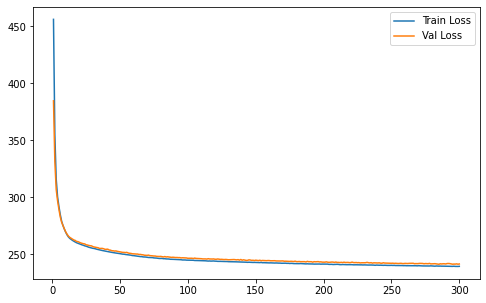

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(history['epochs'], history['train_loss'], label='Train Loss')
plt.plot(history['epochs'], history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [12]:
labels = torch.tensor([i for i in range(10) for _ in range(10)]).unsqueeze(1).to(DEVICE)
z = torch.randn(labels.shape[0], LATENT_SIZE).to(DEVICE)
recon_x = cvae.inference(z, labels).detach().cpu().numpy()

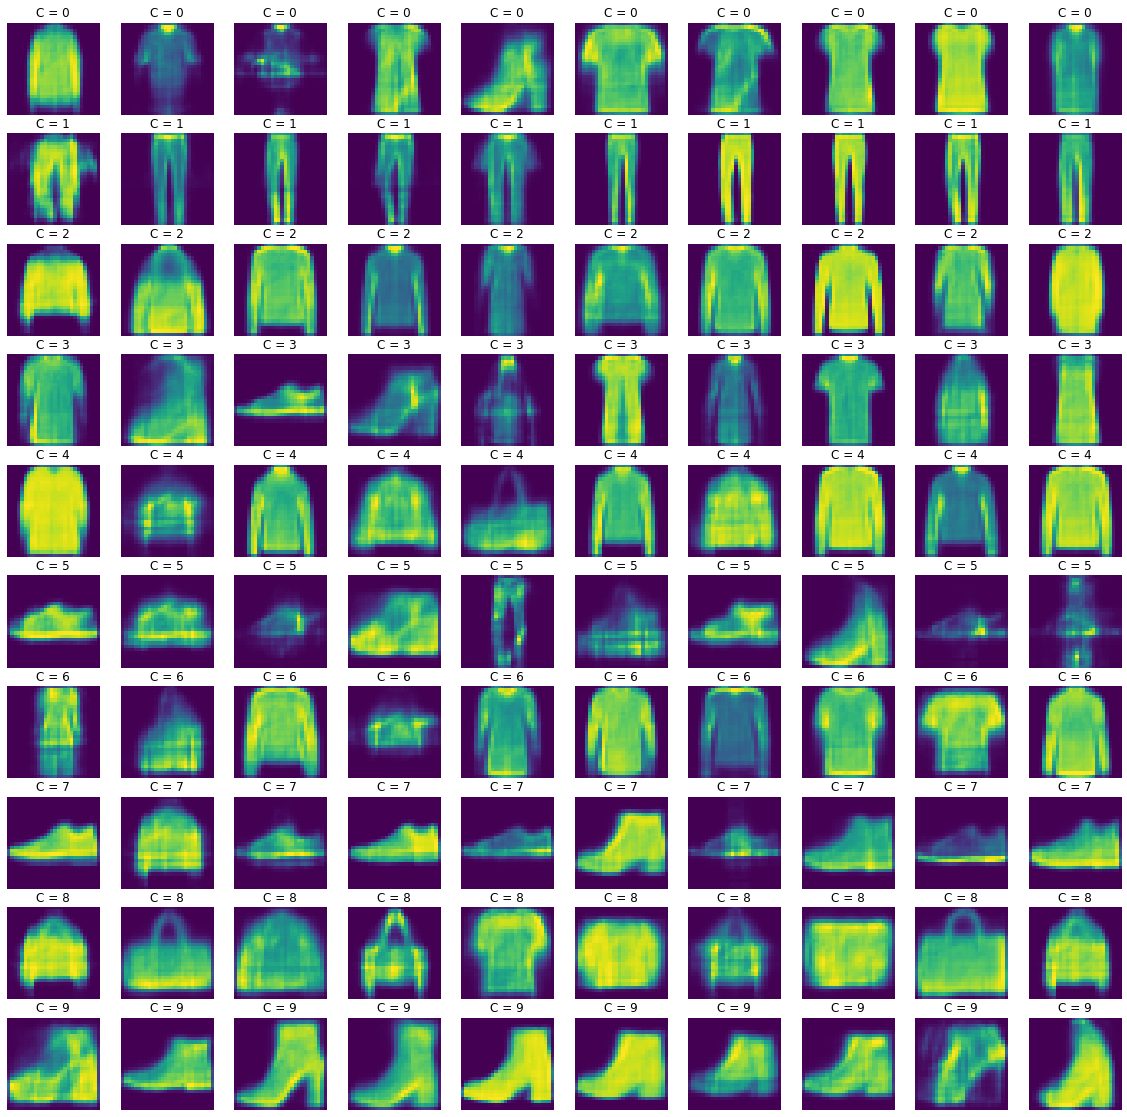

In [13]:
labels_ = labels.view(10, -1).cpu().numpy()
recon_x_ = recon_x.reshape(10, 10, 28, 28)
# prepare figure
fig, ax = plt.subplots(*labels_.shape, figsize=(20,20), sharex=True, sharey=True)
for lbl in labels_:
    for j, i in enumerate(lbl):
        ax[i, j].imshow(recon_x_[i][j])
        ax[i, j].axis('off')
        ax[i, j].set_title(f'C = {i}')
        
plt.show()

After training with 300 epochs, we can see the inference result above. Based on the result, we can conclude that model could generate fashion image according to specified labels. 

But, some of the result also incorrect. We suppose that the model confused to differentiate several images especially label 2, 4, and 6. It can be seen that on those labels, there are images of long sleeves clothes. On the other hand, label 5, 7, and 9 contains images of shoes, but as we can see the model still could differentiate these images even it seems suffering while generating shoes with label 5.